In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IDrefW = 53.98
IDrefL = 85.60

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def getBoxDim(box1):
    # return length and width of rotated rect
    L = box1[1][1]
    W = box1[1][0]
    
    return max(L,W), min(L,W)

def checkCoinDia(rc, Wp, Lp, cent):
    # check if radius is a valid coin
    ## absolute size using L and W, dia (mm)
    ##
    ## dime:        17.91
    ## penny:       19.05
    ## nickel:      21.21
    ## quarter:     24.26
    ## fifty-cent:  30.61
    ## ID-1:        (85.6 x 53.98)
    ## business crd ( 3.5*25.4 x 2.0*25.4 )
    dia = rc * 2.0 * (IDrefW) / Wp
    
    # check coin dia in mm and color flag, penny == True
    result = -1.0
    if dia< 16.2:
        result = -1.0
    elif dia < 18.48:
        if penny == True:
           result = 1.0
        else:
            result = 10.0
    elif dia < 20.13:
        if penny == True:
           result = 1.0
        else:
           result = 10.0
    elif dia < 22.8:
        if penny == True:
            result = 1.0
        else:
            result = 5.0
    elif dia < 27.43:
        result = 25.0
    elif dia < 32.0:
        result = 50.0
   
    return result, dia

def checkCenter(img, cir, thresh = [30,15]):
    # Check if center (x,y) is greater than bkgd threshold
    cir1 = cir.copy()
    radius = np.int32(6)
    # overwrite radius
    cir1[2] = radius
    metric, _ = getCircleColor(img, cir1, 'hsv')

    #yg = (thresh[1]/(thresh[0]+1)) * metric[0] + 10
    #val = metric[0]
      
    if metric[0] < 0.4*thresh[0]:
        return True, metric
    else:
        return False, metric
    

def getCircleColor(image, circ, flag = 'hsv'):
    # return mean of colors over circle from RGB input image
    if flag == 'hsv':
        color = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif flag == 'lab':
        color = cv2.cvtColor(image, cv2.COLOR_BGR2LAB) 
    else:
        color = image
    # https://stackoverflow.com/questions/10469235/opencv-apply-mask-to-a-color-image
    circ = np.uint16(np.around(circ))
    mask = np.full((image.shape[0], image.shape[1]), 0, dtype=np.uint8)   
    cv2.circle(mask, (circ[0], circ[1]), circ[2], (255, 255, 255), -1)
    
    metric = cv2.mean(color, mask)
    
    return metric, mask


def getDimePennyDecision(img, circ):
    # use hsv s-v space to discern dime from pennies
    metric, _ = getCircleColor(img, circ, flag = 'hsv')
    h = metric[0]
    s = metric[1]
    
    penny = True
    if (1.10 * h -s + 38 > 0):
    #if (6.4 * h - s - 75 > 0):
        penny = False
           
    return penny
 
def  findRangeAllContours(contours):
    # find x-y range of ALL objects & ID card
    xmin = 9999
    ymin = 9999
    xmax = 0
    ymax = 0
     
    for c in contours:       
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        if extLeft[0] < xmin:
            xmin = extLeft[0]
        if extRight[0] > xmax:
            xmax = extRight[0]
        if extTop[1] < ymin:
            ymin = extTop[1]
        if extBot[1] > ymax:
            ymax = extBot[1]

        rect = [(xmin,ymin), (xmax,ymax)]

        return rect


def getBkgdMetric(contour, flag = 'hsv'):
    # find color of background
    #
    rectRange = findRangeAllContours(contour)
    x1 = int(rectRange[0][0]/2)
    y1 = int(rectRange[0][1]/2)
    r = int(0.5 * np.sqrt(x1**2 + y1**2))
    circ = [x1, y1, min(r, 15)]
    metric_bkgd, mask_bkgd =  getCircleColor(blurred, circ, 'hsv')

    return metric_bkgd, rectRange

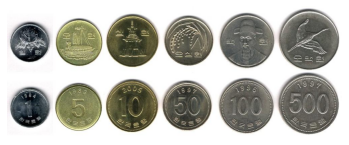

In [3]:
path = './img/coin.jpeg'
img = cv2.imread(path)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Gray_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)

plt.imshow(RGB_img)
plt.axis('off')
plt.show()

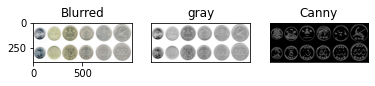

In [4]:
gamma = adjust_gamma(RGB_img, 2.2)
output = gamma.copy()
     
# process image
blurred = cv2.GaussianBlur(gamma, (3,3), 0)
#cv2.imshow("Blurred", blurred) 

gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
#cv2.imshow("gray", gray)

edged = cv2.Canny(gray, 50, 200, 10) # 50,200
#cv2.imshow("Canny", edged)

contours,_ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

metric_bkgd, _ = getBkgdMetric(contours, 'hsv')

cmax = max(contours, key = cv2.contourArea)
rectID = cv2.minAreaRect(cmax)  # find rotated rectangle

pnts = cv2.boxPoints(rectID)
box = np.int0(pnts)
for cnt in contours:
    cv2.drawContours(output,[box],0,(255,0,0),2)
#cv2.drawContours(output,[box],0,(255,0,0),2)



plt.subplot(1,3,1)
plt.title("Blurred")
plt.imshow(blurred, cmap='gray')

imgs = {"gray":gray, "Canny":edged}
for i, (key,value) in enumerate (imgs.items()):
    plt.subplot(1,3,i+2)
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

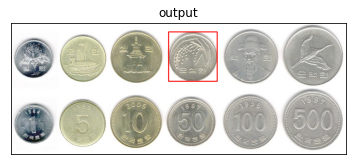

In [6]:
plt.title('output')
plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.show()

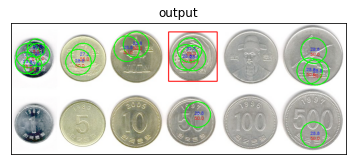

In [13]:
HIGH = 175 # param1
LOW = 45   # param2
circles1 = 25  # set max upper limit for coins
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 20, circles1, \
param1=HIGH, param2=LOW, minRadius=15,maxRadius=40) #12,45

# ensure circles exist
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circlesInt = np.round(circles[0, :]).astype("int")

L , W = getBoxDim(rectID)
coins = 0
item = 0
amount = 0.0


for circ in circlesInt:
    #logging.info([item, circles[item]])
    x = circles[0][item][0]
    y = circles[0][item][1]
    r = circles[0][item][2]

    # check range of x and y within imageCorr
    # --- do it here

    penny = getDimePennyDecision(blurred, circ)
    center, val2 = checkCenter(blurred, circ, thresh = metric_bkgd)

    #print([center, np.around(val2), np.around(metric_bkgd)])
    #print(val2)

    value, dia = checkCoinDia(r, W, L, penny)        
    metric, mask_c =  getCircleColor(blurred, circ, 'hsv')


    if value < 0 or not center:
        color = (0,0,255)
        #cv2.putText(output, "{}".format('X'), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    else:
        coins = coins + 1
        amount = amount + value
        color = (0,255,0)
        # draw the circle in the output image, then print the circle #
        # corresponding to the center of the circle
        cv2.circle(output, (int(x), int(y)), int(r), color, 2)
        cv2.putText(output, "{}".format(int(10*dia)/10), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)    
        # cv2.putText(output, "{}".format(int(metric[ch])), (int(x) - 10, int(y)+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1) 
        cv2.putText(output, "{}".format(value), (int(x) - 10, int(y)+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        item = item + 1
        
    cv2.putText(output, "coin count: {}".format(coins), (30, 610), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(output, "$: {}".format(amount/100.0), (30, 630), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) 
    
    
plt.title('output')
plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
Gray_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)
img2 = RGB_img.copy()
_,grayTH = cv2.threshold(Gray_img, 225, 255,0)

contours,_ = cv2.findContours(grayTH, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    cv2.drawContours(img2, [cnt], 0, (255,0,0),2)
    

plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
grayTH2 = cv2.adaptiveThreshold(Gray_img, 225, cv2.ADAPTIVE_THRESH_MEAN_C,\
cv2.THRESH_BINARY,15,2)

plt.imshow(grayTH, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img3 = RGB_img.copy()

for cnt in contours:
    #cv2.drawContours(RGB_img, [cnt], 0, (255,0,0),2)
    x,y,w,h = cv2.boundingRect(cnt)
    #print(x,y,w,h)
    #cv2.circle(img3,(x+(w/2),y+(h/2)), w/2, (0, 255, 0), 3)
    cv2.circle(img3,(x,y), 2, (0, 255, 0), 3)
               
plt.imshow(img3)

plt.axis('off')
plt.show()